# Time Sequence Prediction

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

In [7]:
import numpy as np
import matplotlib.pyplot as plt

In [8]:
N = 100
L = 1000
T = 20

In [9]:
x = np.empty((N, L), np.float32)
x[:] = np.array(range(L)) + np.random.randint(-4*T, 4*T, N).reshape(N, 1)

In [10]:
y = np.sin(x/1.0/T).astype(np.float32)

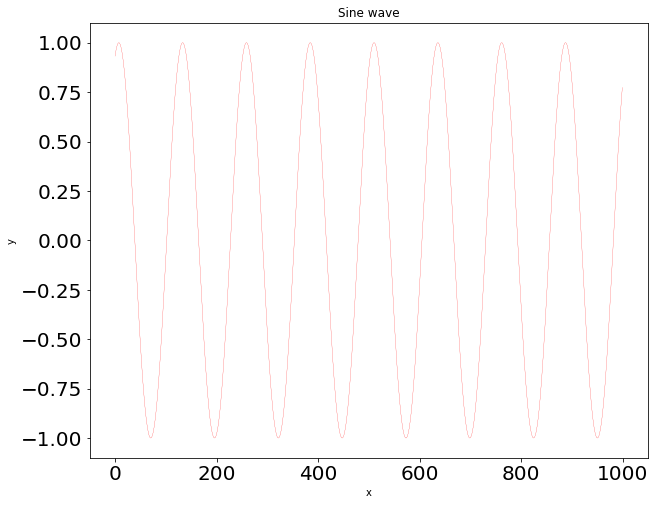

In [15]:
plt.figure(figsize=(10, 8))
plt.title("Sine wave")
plt.xlabel("x")
plt.ylabel("y")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(np.arange(x.shape[1]), y[0,:], 'r', linewidth=0.2)
# plt.show()

In [20]:
class LSTMPredictor(nn.Module):
    def __init__(self, n_hidden=51):
        super(LSTMPredictor, self).__init__()
        self.n_hidden = n_hidden
        self.lstm1 = nn.LSTMCell(1, self.n_hidden)
        self.lstm2 = nn.LSTMCell(self.n_hidden, self.n_hidden)
        self.linear = nn.Linear(self.n_hidden, 1)

    def forward(self, x, future=0):
        outputs = []
        n_samples = x.size(0)

        h_t = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)
        c_t = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)
        h_t2 = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)
        c_t2 = torch.zeros(n_samples, self.n_hidden, dtype=torch.float32)

        for input_t in x.split(1, dim=1):
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)

        for i in range(future):
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)

        outputs = torch.cat(outputs, dim=1)
        return outputs

Step 0
loss 0.5293172597885132
loss 0.5181604027748108
loss 0.49176087975502014
loss 0.4796116054058075
loss 0.435808002948761
loss 0.73972088098526
loss 0.25079643726348877
loss 0.11440128087997437
loss 0.8802663087844849
loss 0.02063942886888981
loss 0.01940937712788582
loss 0.018182704225182533
loss 0.016759639605879784
loss 0.014289993792772293
loss 0.010617654770612717
loss 0.005589309614151716
loss 0.0036910218186676502
loss 0.002815007697790861
loss 0.0018864595331251621
loss 0.0015321850078180432
test loss 0.002565113827586174


ValueError: x and y must have same first dimension, but have shapes (1999,) and (1000,)

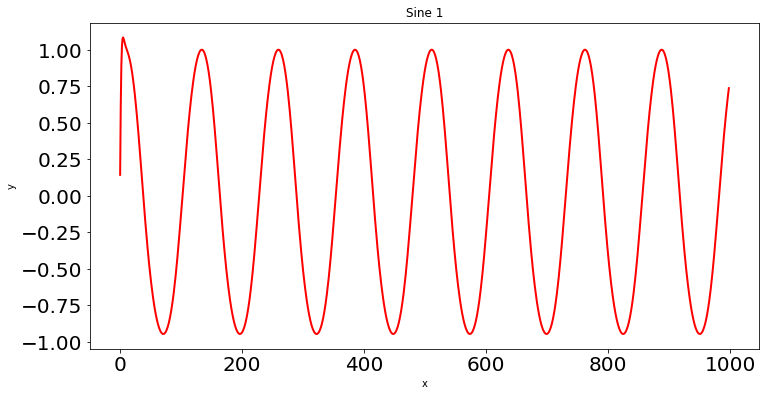

In [21]:
if __name__ == "__main__":
    train_input = torch.from_numpy(y[3:, :-1])
    train_target = torch.from_numpy(y[3:, 1:])
    test_input = torch.from_numpy(y[:3, :-1])
    test_target = torch.from_numpy(y[:3, 1:])

    model = LSTMPredictor()
    criterion = nn.MSELoss()
    optimizer = optim.LBFGS(model.parameters(), lr=0.8)

    n_steps = 10
    for i in range(n_steps):
        print("Step", i)

        def closure():
            optimizer.zero_grad()
            out = model(train_input)
            loss = criterion(out, train_input)
            print("loss", loss.item())
            loss.backward()
            return loss
        optimizer.step(closure)

        with torch.no_grad():
            future = 1000
            pred = model(test_input, future=future)
            loss = criterion(pred[:, :-future], test_target)
            print("test loss", loss.item())
            y = pred.detach().numpy()

        plt.figure(figsize=(12, 6))
        plt.title(f"Sine {i+1}")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        n = train_input.shape[1]

        def draw(y_i, color):
            plt.plot(np.arange(n), y_i[:n], color, linewidth=2.0)
            plt.plot(np.arange(n+future), y_i[n:], color + ":", linewidth=2.0)

        draw(y[0], 'r')
        draw(y[1], 'b')
        draw(y[2], 'g')
        plt.show()